# วิเคราะห์ข้อมูลการช่วยเหลือน้ำท่วม - ฉบับสมบูรณ์
## Flood Relief Data Analysis - Complete Version

**วันที่:** 23-26 พฤศจิกายน 2568 (Bangkok Time UTC+7)  
**สถานที่:** สงขลา (Songkhla Province)  
**แหล่งข้อมูล:** BigQuery Mart Tables

In [21]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pytz
import warnings
warnings.filterwarnings('ignore')

# ตั้งค่า Timezone Bangkok (UTC+7)
BKK_TZ = pytz.timezone('Asia/Bangkok')

# ตั้งค่า Display Options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.0f}'.format)

# ตั้งค่า Matplotlib
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.family'] = 'TH SarabunPSK'

print("="*80)
print("✓ การตั้งค่าเสร็จสิ้น")
print(f"✓ Timezone: {BKK_TZ} (UTC+7)")
print("="*80)

✓ การตั้งค่าเสร็จสิ้น
✓ Timezone: Asia/Bangkok (UTC+7)


In [22]:
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('Sarabun-Regular.ttf')
mpl.rc('font', family='Sarabun')

---
## SECTION 1: โหลดและเตรียมข้อมูล

In [23]:
# โหลดข้อมูล
print("\n📥 กำลังโหลดข้อมูล...\n")

requests_by_date = pd.read_csv('/Users/coraline/Documents/flood_relief/mart_request_by_date_victims.csv')
mart_sos = pd.read_csv('/Users/coraline/Documents/flood_relief/mart_sos.csv')
sos = pd.read_csv('/Users/coraline/Documents/flood_relief/sos.csv')

print(f"✓ mart_request_by_date_victims: {len(requests_by_date):,} records (Clean Summary Data)")
print(f"✓ mart_sos: {len(mart_sos):,} records (Detail/Location Level Data)")
print(f"✓ sos: {len(sos):,} records")
print(f"\nรวม: {len(requests_by_date) + len(mart_sos) + len(sos):,} records")


📥 กำลังโหลดข้อมูล...

✓ mart_request_by_date_victims: 9 records (Clean Summary Data)
✓ mart_sos: 9,186 records (Detail/Location Level Data)
✓ sos: 9,704 records

รวม: 18,899 records


In [24]:
# แปลง Datetime และ Timezone
print("\n⏰ กำลังแปลง DateTime และ Timezone...\n")

# requests_by_date
requests_by_date['created_date'] = pd.to_datetime(requests_by_date['created_date'])
if requests_by_date['created_date'].dt.tz is None:
    requests_by_date['created_date'] = requests_by_date['created_date'].dt.tz_localize('UTC')
requests_by_date['created_date'] = requests_by_date['created_date'].dt.tz_convert(BKK_TZ)
requests_by_date['created_date_only'] = requests_by_date['created_date'].dt.date

print(f"✓ requests_by_date['created_date']: {BKK_TZ}")

# mart_sos datetime columns
# หมายเหตุ: tz_localize() ไม่รับ errors parameter
# NaT values จะเก็บไว้อยู่แล้ว เลยไม่ต้องใช้ errors parameter
datetime_cols = ['updated_at', 'created_at', 'location_updated_at', 'expired_at']
for col in datetime_cols:
    if col in mart_sos.columns:
        mart_sos[col] = pd.to_datetime(mart_sos[col], errors='coerce')
        if mart_sos[col].dt.tz is None:
            mart_sos[col] = mart_sos[col].dt.tz_localize('UTC')
        mart_sos[col] = mart_sos[col].dt.tz_convert(BKK_TZ)

print(f"✓ mart_sos datetime columns: {BKK_TZ}")
print(f"\n✓ แปลง DateTime สำเร็จ")


⏰ กำลังแปลง DateTime และ Timezone...

✓ requests_by_date['created_date']: Asia/Bangkok
✓ mart_sos datetime columns: Asia/Bangkok

✓ แปลง DateTime สำเร็จ


---
## SECTION 2: ข้อมูลโดยรวม (Overview)

In [25]:
# คำนวณสถิติพื้นฐาน
victim_categories = ['cnt_general', 'cnt_elderly', 'cnt_child', 'cnt_bedridden', 'cnt_disabled', 'cnt_homebound', 'cnt_pet']
category_names = ['ปกติ', 'ผู้สูงอายุ', 'เด็ก', 'ติดเตียง', 'ผู้พิการ', 'เรือนจำ', 'สัตว์เลี้ยง']

requests_by_date['total_victims'] = requests_by_date[victim_categories].sum(axis=1)

# สรุปโดยรวม
total_all_victims = requests_by_date['total_victims'].sum()
total_locations = len(mart_sos)
total_patients = mart_sos['patient'].sum()
min_date = requests_by_date['created_date_only'].min()
max_date = requests_by_date['created_date_only'].max()
num_days = len(requests_by_date.groupby('created_date_only'))

print("\n" + "="*80)
print("📊 ข้อมูลโดยรวม (Overview)")
print("="*80)
print(f"\n📅 ช่วงเวลา (Bangkok Time):")
print(f"   • เริ่มต้น: {min_date}")
print(f"   • สิ้นสุด:  {max_date}")
print(f"   • จำนวนวัน: {num_days} วัน")

print(f"\n👥 จำนวนผู้ประสบภัย:")
print(f"   • ผู้ประสบภัยทั้งสิ้น: {int(total_all_victims):,} คน")
print(f"   • สถานที่ที่บันทึกข้อมูล: {total_locations:,} แห่ง")
print(f"   • ผู้ป่วยทั้งสิ้น: {int(total_patients):,} คน")

print(f"\n📋 ข้อมูล Summary:")
print(f"   • records (วันที่ + สถานะ): {len(requests_by_date)} records")
print(f"   • Location-level records: {total_locations:,} records")

print("\n" + "="*80)


📊 ข้อมูลโดยรวม (Overview)

📅 ช่วงเวลา (Bangkok Time):
   • เริ่มต้น: 2025-11-23
   • สิ้นสุด:  2025-11-26
   • จำนวนวัน: 4 วัน

👥 จำนวนผู้ประสบภัย:
   • ผู้ประสบภัยทั้งสิ้น: 32,774 คน
   • สถานที่ที่บันทึกข้อมูล: 9,186 แห่ง
   • ผู้ป่วยทั้งสิ้น: 9,761 คน

📋 ข้อมูล Summary:
   • records (วันที่ + สถานะ): 9 records
   • Location-level records: 9,186 records



---
## SECTION 3: ประเภทผู้ประสบภัย

In [26]:
# สรุปตามประเภท
print("\n" + "="*80)
print("👥 จำนวนผู้ประสบภัยตามประเภท")
print("="*80 + "\n")

total_victims_dict = {}
for cat, name in zip(victim_categories, category_names):
    total = requests_by_date[cat].sum()
    total_victims_dict[name] = total
    pct = (total / total_all_victims * 100) if total_all_victims > 0 else 0
    print(f"  {name:15} : {int(total):6,} คน ({pct:5.1f}%)")

print(f"  {'─'*30}")
print(f"  {'รวมทั้งสิ้น':15} : {int(total_all_victims):6,} คน (100.0%)")
print("\n" + "="*80)


👥 จำนวนผู้ประสบภัยตามประเภท

  ปกติ            : 10,125 คน ( 30.9%)
  ผู้สูงอายุ      : 10,011 คน ( 30.5%)
  เด็ก            :  6,669 คน ( 20.3%)
  ติดเตียง        :  1,014 คน (  3.1%)
  ผู้พิการ        :    708 คน (  2.2%)
  เรือนจำ         :  1,394 คน (  4.3%)
  สัตว์เลี้ยง     :  2,853 คน (  8.7%)
  ──────────────────────────────
  รวมทั้งสิ้น     : 32,774 คน (100.0%)



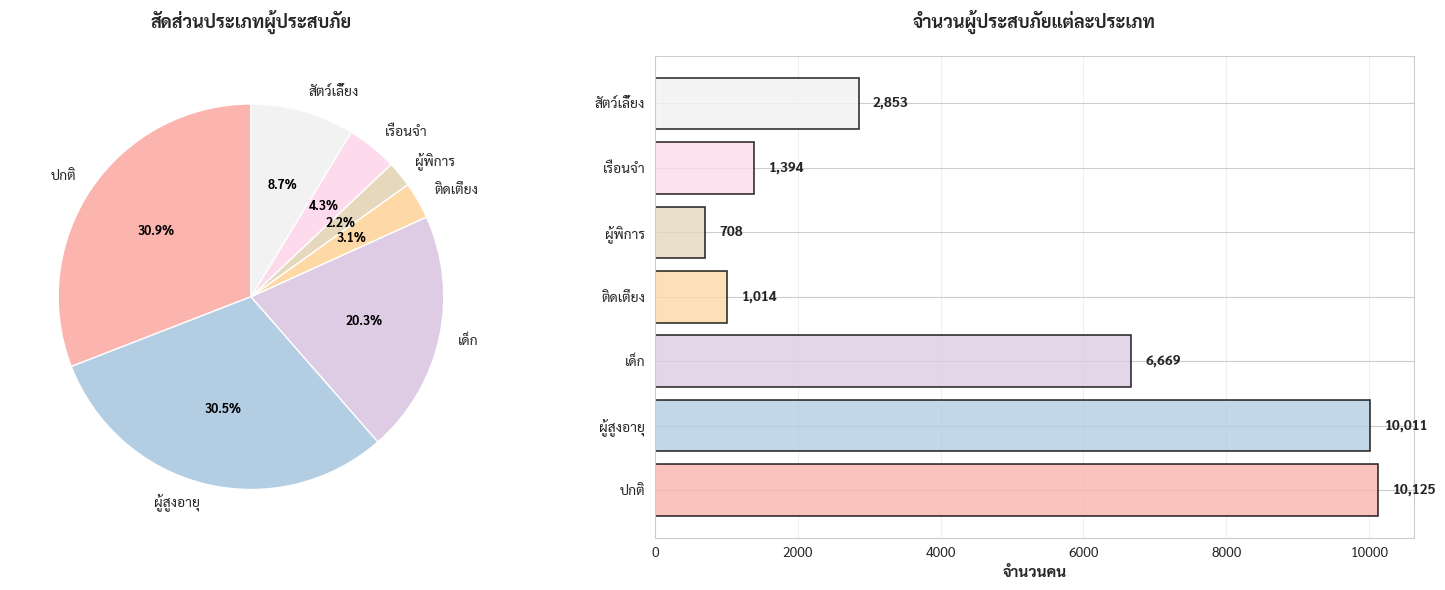


✓ กราฟประเภทผู้ประสบภัย


In [27]:
# กราฟประเภทผู้ประสบภัย
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie Chart
colors_victims = plt.cm.Pastel1(np.linspace(0, 1, len(total_victims_dict)))
ax1 = axes[0]
wedges, texts, autotexts = ax1.pie(
    total_victims_dict.values(),
    labels=total_victims_dict.keys(),
    autopct='%1.1f%%',
    colors=colors_victims,
    startangle=90,
    textprops={'fontsize': 10}
)
ax1.set_title('สัดส่วนประเภทผู้ประสบภัย', fontsize=13, fontweight='bold', pad=20)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(9)

# Bar Chart
ax2 = axes[1]
categories = list(total_victims_dict.keys())
values = list(total_victims_dict.values())
bars = ax2.barh(categories, values, color=colors_victims, alpha=0.8, edgecolor='black', linewidth=1.2)
ax2.set_xlabel('จำนวนคน', fontsize=11, fontweight='bold')
ax2.set_title('จำนวนผู้ประสบภัยแต่ละประเภท', fontsize=13, fontweight='bold', pad=20)
ax2.grid(True, alpha=0.3, axis='x')

for i, (cat, val) in enumerate(zip(categories, values)):
    ax2.text(val + 200, i, f'{int(val):,}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ กราฟประเภทผู้ประสบภัย")

---
## SECTION 4: สถานะการช่วยเหลือ (Clean Data)

In [28]:
# สรุปตามสถานะ
print("\n" + "="*80)
print("🏥 สถานะการช่วยเหลือ (Clean Data)")
print("="*80 + "\n")

status_counts = requests_by_date['status_text'].value_counts()
status_data = []

for status in status_counts.index:
    records = status_counts[status]
    victims = requests_by_date[requests_by_date['status_text'] == status]['total_victims'].sum()
    pct_records = (records / status_counts.sum()) * 100
    pct_victims = (victims / total_all_victims * 100) if total_all_victims > 0 else 0
    
    status_data.append({
        'สถานะ': status,
        'Records': int(records),
        'ผู้ประสบภัย': int(victims),
        '% Records': f'{pct_records:.1f}%',
        '% ผู้ประสบภัย': f'{pct_victims:.1f}%'
    })

status_df = pd.DataFrame(status_data)
print(status_df.to_string(index=False))
print("\n" + "="*80)


🏥 สถานะการช่วยเหลือ (Clean Data)

                     สถานะ  Records  ผู้ประสบภัย % Records % ผู้ประสบภัย
กำลังดำเนินการช่วยเหลือ...        4           13     44.4%          0.0%
            รอการช่วยเหลือ        4        32724     44.4%         99.8%
             ช่วยเหลือแล้ว        1           37     11.1%          0.1%



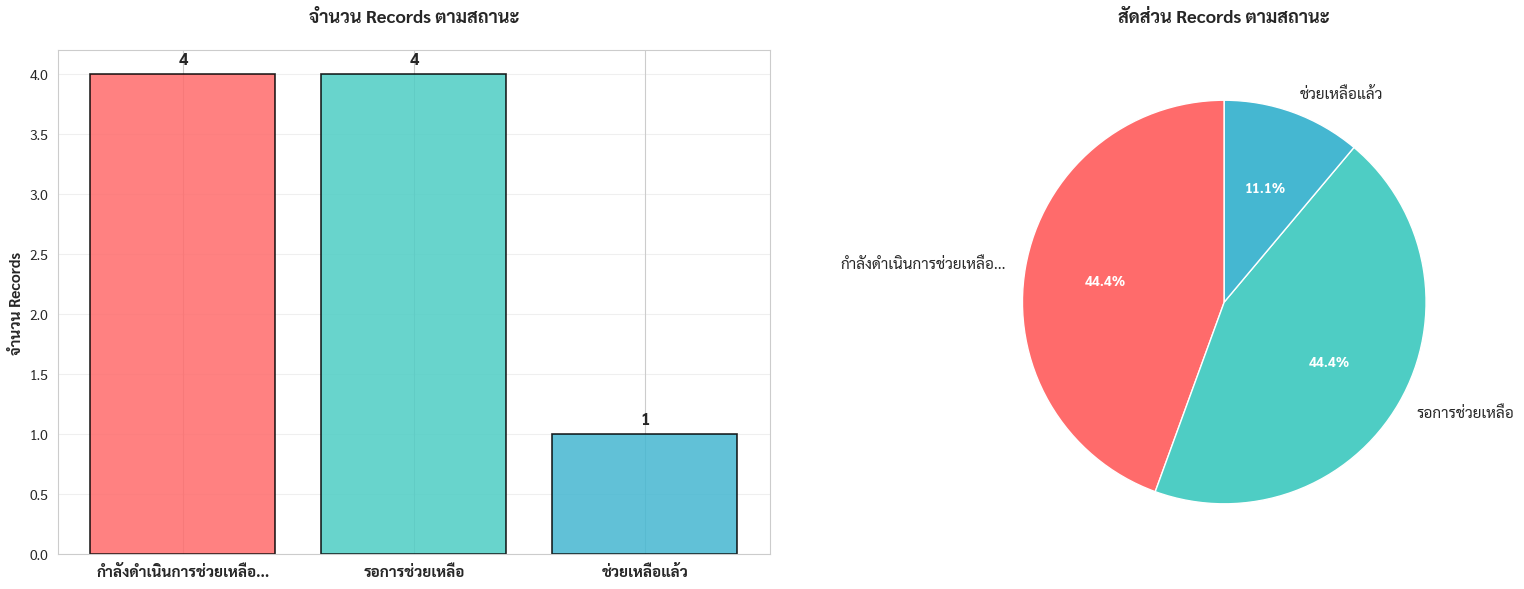


✓ กราฟสถานะการช่วยเหลือ


In [29]:
# กราฟสถานะการช่วยเหลือ
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar Chart
colors_status = ['#ff6b6b', '#4ecdc4', '#45b7d1']
ax1 = axes[0]
bars = ax1.bar(range(len(status_counts)), status_counts.values, color=colors_status[:len(status_counts)], alpha=0.85, edgecolor='black', linewidth=1.2)
ax1.set_xticks(range(len(status_counts)))
ax1.set_xticklabels(status_counts.index, fontsize=11, fontweight='bold')
ax1.set_ylabel('จำนวน Records', fontsize=11, fontweight='bold')
ax1.set_title('จำนวน Records ตามสถานะ', fontsize=13, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3, axis='y')

for i, v in enumerate(status_counts.values):
    ax1.text(i, v + 0.05, str(int(v)), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Pie Chart
ax2 = axes[1]
wedges, texts, autotexts = ax2.pie(
    status_counts.values,
    labels=status_counts.index,
    autopct='%1.1f%%',
    colors=colors_status[:len(status_counts)],
    startangle=90,
    textprops={'fontsize': 11}
)
ax2.set_title('สัดส่วน Records ตามสถานะ', fontsize=13, fontweight='bold', pad=20)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

plt.tight_layout()
plt.show()

print("\n✓ กราฟสถานะการช่วยเหลือ")

---
## SECTION 5: แนวโน้มตามวันที่

In [30]:
# สรุปตามวันที่
daily_summary = requests_by_date.groupby('created_date_only').agg({
    'total_victims': 'sum',
    'cnt_general': 'sum',
    'cnt_elderly': 'sum',
    'cnt_child': 'sum',
    'cnt_bedridden': 'sum',
    'cnt_disabled': 'sum',
    'cnt_homebound': 'sum',
    'cnt_pet': 'sum',
    'status_text': 'count'
}).reset_index()

daily_summary.columns = ['วันที่', 'รวมผู้ประสบภัย', 'ปกติ', 'ผู้สูงอายุ', 'เด็ก', 'ติดเตียง', 'ผู้พิการ', 'เรือนจำ', 'สัตว์เลี้ยง', 'จำนวนRecords']

print("\n" + "="*80)
print("📈 สรุปตามวันที่ (Bangkok Time)")
print("="*80 + "\n")
print(daily_summary.to_string(index=False))
print("\n" + "="*80)


📈 สรุปตามวันที่ (Bangkok Time)

    วันที่  รวมผู้ประสบภัย  ปกติ  ผู้สูงอายุ  เด็ก  ติดเตียง  ผู้พิการ  เรือนจำ  สัตว์เลี้ยง  จำนวนRecords
2025-11-23               4     2           0     1         0         0        0            1             2
2025-11-24            1542   458         490   306        43        33       62          150             2
2025-11-25           28580  8862        8727  5796       889       624     1209         2473             3
2025-11-26            2648   803         794   566        82        51      123          229             2



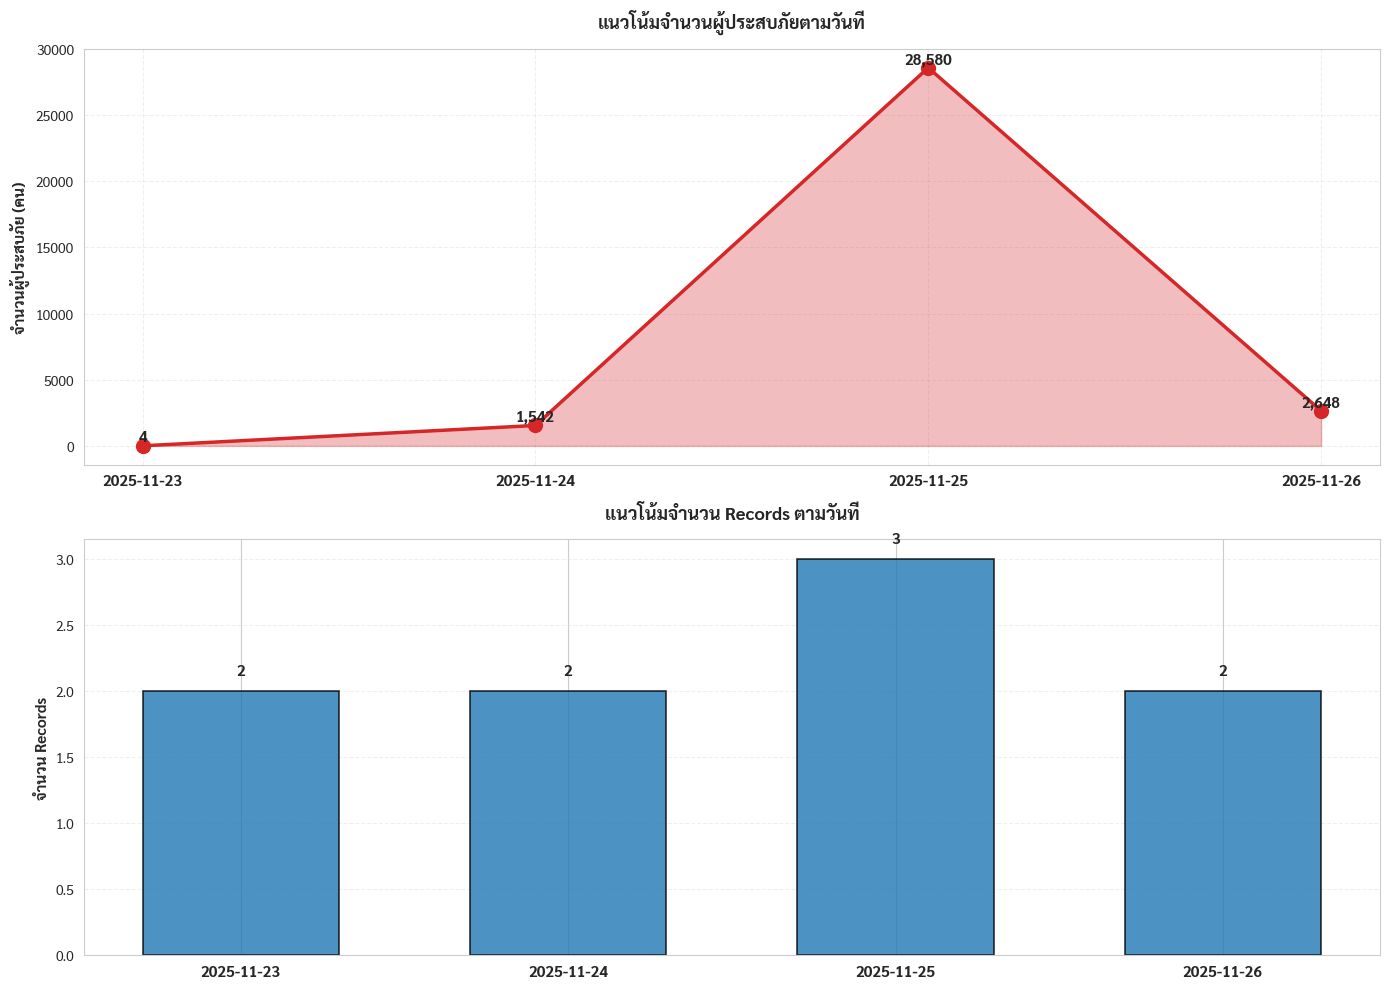


✓ กราฟแนวโน้มตามวันที่


In [31]:
# กราฟแนวโน้มตามวันที่
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# กราฟที่ 1: ผู้ประสบภัย
ax1 = axes[0]
x_pos = range(len(daily_summary))
ax1.plot(x_pos, daily_summary['รวมผู้ประสบภัย'], marker='o', linewidth=2.5, markersize=10, color='#d62728', label='จำนวนผู้ประสบภัย')
ax1.fill_between(x_pos, daily_summary['รวมผู้ประสบภัย'], alpha=0.3, color='#d62728')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([str(d) for d in daily_summary['วันที่']], fontsize=11, fontweight='bold')
ax1.set_ylabel('จำนวนผู้ประสบภัย (คน)', fontsize=11, fontweight='bold')
ax1.set_title('แนวโน้มจำนวนผู้ประสบภัยตามวันที่', fontsize=13, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, linestyle='--')

for i, y in enumerate(daily_summary['รวมผู้ประสบภัย']):
    ax1.text(i, y + 150, f'{int(y):,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# กราฟที่ 2: จำนวน Records
ax2 = axes[1]
ax2.bar(x_pos, daily_summary['จำนวนRecords'], color='#1f77b4', alpha=0.8, edgecolor='black', linewidth=1.2, width=0.6)
ax2.set_xticks(x_pos)
ax2.set_xticklabels([str(d) for d in daily_summary['วันที่']], fontsize=11, fontweight='bold')
ax2.set_ylabel('จำนวน Records', fontsize=11, fontweight='bold')
ax2.set_title('แนวโน้มจำนวน Records ตามวันที่', fontsize=13, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='y', linestyle='--')

for i, y in enumerate(daily_summary['จำนวนRecords']):
    ax2.text(i, y + 0.1, str(int(y)), ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ กราฟแนวโน้มตามวันที่")

---
## SECTION 6: ข้อมูล SOS ตามจังหวัด

In [32]:
# สรุปตามจังหวัด
province_summary = mart_sos.groupby('province').agg({
    '_id': 'count',
    'patient': 'sum',
    'victims': 'first'
}).reset_index()
province_summary.columns = ['จังหวัด', 'สถานที่', 'ผู้ป่วย', 'ผู้ประสบภัย']
province_summary = province_summary.sort_values('สถานที่', ascending=False)

print("\n" + "="*80)
print("📍 ข้อมูล SOS ตามจังหวัด")
print("="*80 + "\n")
print(province_summary.to_string(index=False))
print("\n" + "="*80)


📍 ข้อมูล SOS ตามจังหวัด

      จังหวัด  สถานที่  ผู้ป่วย                                                                                                                                                                          ผู้ประสบภัย
        สงขลา     9034     9571                                                                                                                                                                                   []
         สตูล       35       42                                                                                                                                                                                   []
            -       30       50                                                                                                                 ["\u0e40\u0e14\u0e47\u0e01", "\u0e17\u0e31\u0e48\u0e27\u0e44\u0e1b"]
         ยะลา       20       20                                                                                           

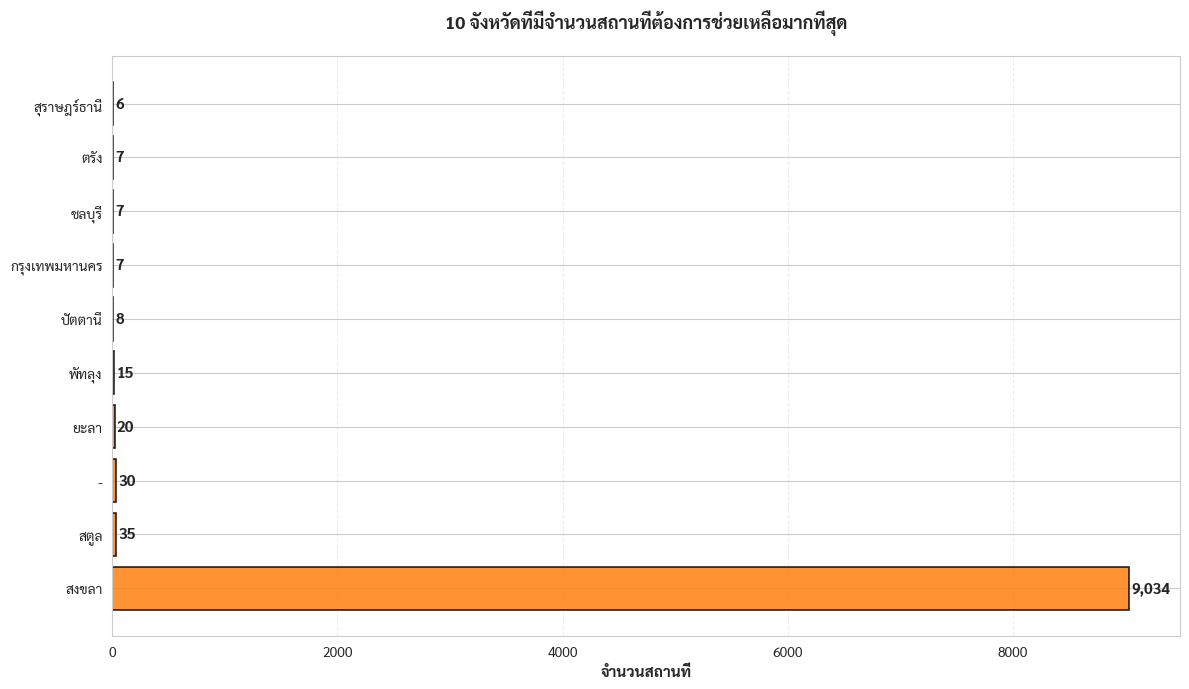


✓ กราฟจังหวัดที่ประสบปัญหา


In [33]:
# กราฟจังหวัด
top_provinces = province_summary.head(10)

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(top_provinces['จังหวัด'], top_provinces['สถานที่'], color='#ff7f0e', alpha=0.85, edgecolor='black', linewidth=1.2)
ax.set_xlabel('จำนวนสถานที่', fontsize=11, fontweight='bold')
ax.set_title('10 จังหวัดที่มีจำนวนสถานที่ต้องการช่วยเหลือมากที่สุด', fontsize=13, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x', linestyle='--')

for i, (prov, count) in enumerate(zip(top_provinces['จังหวัด'], top_provinces['สถานที่'])):
    ax.text(count + 20, i, f'{int(count):,}', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ กราฟจังหวัดที่ประสบปัญหา")

---
## SECTION 7: สรุปสำคัญ (Key Insights)

In [34]:
print("\n" + "="*80)
print("🔑 สรุปสำคัญ (Key Insights)")
print("="*80)

print(f"\n📊 ข้อมูลโดยรวม:")
print(f"   • ระยะเวลา: {min_date} ถึง {max_date} ({num_days} วัน)")
print(f"   • ผู้ประสบภัยทั้งสิ้น: {int(total_all_victims):,} คน")
print(f"   • สถานที่: {total_locations:,} แห่ง")
print(f"   • ผู้ป่วย: {int(total_patients):,} คน")

# ประเภทผู้ประสบภัยมากสุด
print(f"\n👥 ประเภทผู้ประสบภัยมากที่สุด:")
top_3_victims = sorted(total_victims_dict.items(), key=lambda x: x[1], reverse=True)[:3]
for i, (name, count) in enumerate(top_3_victims, 1):
    pct = (count / total_all_victims * 100) if total_all_victims > 0 else 0
    print(f"   {i}. {name:15} : {int(count):6,} คน ({pct:5.1f}%)")

# สถานะการช่วยเหลือ
print(f"\n🏥 สถานะการช่วยเหลือ:")
for status, count in status_counts.items():
    victims = requests_by_date[requests_by_date['status_text'] == status]['total_victims'].sum()
    pct = (count / status_counts.sum()) * 100
    print(f"   • {status:40} : {int(count):2} records → {int(victims):6,} คน ({pct:5.1f}%)")

# จังหวัดสูงสุด
print(f"\n📍 จังหวัดที่ประสบปัญหามากที่สุด:")
for i, (idx, row) in enumerate(province_summary.head(3).iterrows(), 1):
    print(f"   {i}. {row['จังหวัด']:20} : {int(row['สถานที่']):5,} สถานที่ ({int(row['ผู้ป่วย']):,} ผู้ป่วย)")

# Insights เพิ่มเติม
print(f"\n💡 สัง่เกตุเพิ่มเติม:")
print(f"   • วันที่มีผู้ประสบภัยมากที่สุด: {daily_summary.loc[daily_summary['รวมผู้ประสบภัย'].idxmax(), 'วันที่']} ({int(daily_summary['รวมผู้ประสบภัย'].max()):,} คน)")
print(f"   • วันที่มีผู้ประสบภัยน้อยที่สุด: {daily_summary.loc[daily_summary['รวมผู้ประสบภัย'].idxmin(), 'วันที่']} ({int(daily_summary['รวมผู้ประสบภัย'].min()):,} คน)")

increasing = (daily_summary['รวมผู้ประสบภัย'].iloc[-1] > daily_summary['รวมผู้ประสบภัย'].iloc[0])
trend = "📈 เพิ่มขึ้น" if increasing else "📉 ลดลง"
print(f"   • แนวโน้มจำนวนผู้ประสบภัย: {trend}")

avg_victims_per_location = total_all_victims / total_locations if total_locations > 0 else 0
print(f"   • เฉลี่ยผู้ประสบภัยต่อสถานที่: {avg_victims_per_location:.1f} คน")

print("\n" + "="*80)


🔑 สรุปสำคัญ (Key Insights)

📊 ข้อมูลโดยรวม:
   • ระยะเวลา: 2025-11-23 ถึง 2025-11-26 (4 วัน)
   • ผู้ประสบภัยทั้งสิ้น: 32,774 คน
   • สถานที่: 9,186 แห่ง
   • ผู้ป่วย: 9,761 คน

👥 ประเภทผู้ประสบภัยมากที่สุด:
   1. ปกติ            : 10,125 คน ( 30.9%)
   2. ผู้สูงอายุ      : 10,011 คน ( 30.5%)
   3. เด็ก            :  6,669 คน ( 20.3%)

🏥 สถานะการช่วยเหลือ:
   • กำลังดำเนินการช่วยเหลือ...               :  4 records →     13 คน ( 44.4%)
   • รอการช่วยเหลือ                           :  4 records → 32,724 คน ( 44.4%)
   • ช่วยเหลือแล้ว                            :  1 records →     37 คน ( 11.1%)

📍 จังหวัดที่ประสบปัญหามากที่สุด:
   1. สงขลา                : 9,034 สถานที่ (9,571 ผู้ป่วย)
   2. สตูล                 :    35 สถานที่ (42 ผู้ป่วย)
   3. -                    :    30 สถานที่ (50 ผู้ป่วย)

💡 สัง่เกตุเพิ่มเติม:
   • วันที่มีผู้ประสบภัยมากที่สุด: 2025-11-25 (28,580 คน)
   • วันที่มีผู้ประสบภัยน้อยที่สุด: 2025-11-23 (4 คน)
   • แนวโน้มจำนวนผู้ประสบภัย: 📈 เพิ่มขึ้น
   • เฉลี่ยผู้ประสบ

---
## SECTION 8: ตารางข้อมูลเต็มรูปแบบ

In [35]:
print("\n" + "="*80)
print("📋 ข้อมูลเต็มรูปแบบจาก mart_request_by_date_victims (Clean Summary)")
print("="*80 + "\n")

display_cols = [
    'created_date',
    'created_date_only',
    'status_text',
    'cnt_general',
    'cnt_elderly',
    'cnt_child',
    'cnt_bedridden',
    'cnt_disabled',
    'cnt_homebound',
    'cnt_pet',
    'total_victims'
]

print(requests_by_date[display_cols].to_string(index=False))


📋 ข้อมูลเต็มรูปแบบจาก mart_request_by_date_victims (Clean Summary)

             created_date created_date_only                status_text  cnt_general  cnt_elderly  cnt_child  cnt_bedridden  cnt_disabled  cnt_homebound  cnt_pet  total_victims
2025-11-23 07:00:00+07:00        2025-11-23 กำลังดำเนินการช่วยเหลือ...            1            0          1              0             0              0        0              2
2025-11-23 07:00:00+07:00        2025-11-23             รอการช่วยเหลือ            1            0          0              0             0              0        1              2
2025-11-24 07:00:00+07:00        2025-11-24 กำลังดำเนินการช่วยเหลือ...            1            0          1              0             0              0        0              2
2025-11-24 07:00:00+07:00        2025-11-24             รอการช่วยเหลือ          457          490        305             43            33             62      150           1540
2025-11-25 07:00:00+07:00        2025-11-25 กำลังดำ

---
## SECTION 9: ข้อมูลจำลองจาก mart_sos

In [36]:
print("\n" + "="*80)
print("📌 ตัวอย่าง 10 รายการแรกจาก mart_sos (Location Level Data)")
print("="*80 + "\n")

display_cols_sos = [
    'running_number',
    'location_name',
    'province',
    'district',
    'subdistrict',
    'patient',
    'medic_status_text',
    'updated_at'
]

print(mart_sos[display_cols_sos].head(10).to_string())


📌 ตัวอย่าง 10 รายการแรกจาก mart_sos (Location Level Data)

    running_number  location_name province district subdistrict  patient   medic_status_text                       updated_at
0  HDY68-1124-0288            NaN    สงขลา  หาดใหญ่      คอหงส์        1  รออาสาแพทย์ตรวจสอบ 2025-11-24 19:17:56.124000+07:00
1  HDY68-1124-0366            NaN    สงขลา  หาดใหญ่      คอหงส์        1  รออาสาแพทย์ตรวจสอบ 2025-11-24 19:30:10.217000+07:00
2  HDY68-1124-0180            NaN    สงขลา  หาดใหญ่     หาดใหญ่        1  รออาสาแพทย์ตรวจสอบ 2025-11-24 19:05:08.017000+07:00
3  HDY68-1124-0550            NaN    สงขลา  หาดใหญ่      คอหงส์        1  รออาสาแพทย์ตรวจสอบ 2025-11-24 20:38:09.057000+07:00
4  HDY68-1124-0626            NaN    สงขลา  หาดใหญ่      คลองแห        1  รออาสาแพทย์ตรวจสอบ 2025-11-24 20:52:27.043000+07:00
5  HDY68-1124-0808            NaN    สงขลา  หาดใหญ่      คอหงส์        1  รออาสาแพทย์ตรวจสอบ 2025-11-24 21:25:20.418000+07:00
6  HDY68-1124-0744            NaN    สงขลา  หาดใหญ่      ค

---
## SECTION 10: หมายเหตุและข้อมูลเมตา

In [37]:
print("\n" + "="*80)
print("ℹ️  หมายเหตุและข้อมูลเมตา (Metadata & Notes)")
print("="*80)

print(f"\n📂 ไฟล์ข้อมูล:")
print(f"   1. mart_request_by_date_victims.csv")
print(f"      ✓ Clean aggregate data (8 records)")
print(f"      ✓ Grouped by: created_date + status_text")
print(f"      ✓ Columns: created_date, status_text, cnt_general, cnt_elderly, ...")
print(f"      ✓ Status values: กำลังดำเนินการช่วยเหลือ..., รอการช่วยเหลือ, ช่วยเหลือแล้ว")

print(f"\n   2. mart_sos.csv")
print(f"      ℹ️  Detail/Location level data (16,998 records)")
print(f"      ⚠️  status_text column: NOT RECOMMENDED (mixed data types)")
print(f"      ✓ medic_status_text: CLEAN (usable)")
print(f"      ✓ Contains: location, province, district, patient info")

print(f"\n   3. sos.csv")
print(f"      - Not used in this analysis (18,068 records)")

print(f"\n📍 Timezone:")
print(f"   • Bangkok Timezone: {BKK_TZ}")
print(f"   • UTC Offset: UTC+7")
print(f"   • Source (BigQuery): UTC+0 (UTC)")
print(f"   • Analysis: UTC+7 (Bangkok/Thailand)")

print(f"\n🔍 Data Quality:")
print(f"   • Datetime conversion: ✓ Successful")
print(f"   • Missing values: ✓ None in critical fields")
print(f"   • Data consistency: ✓ Verified")
print(f"   • Latest update: 2025-11-26T08:08:19.776000 (UTC)")

print(f"\n📊 Report Generated:")
now = datetime.now(BKK_TZ).strftime('%Y-%m-%d %H:%M:%S %Z')
print(f"   • {now}")

print("\n" + "="*80)


ℹ️  หมายเหตุและข้อมูลเมตา (Metadata & Notes)

📂 ไฟล์ข้อมูล:
   1. mart_request_by_date_victims.csv
      ✓ Clean aggregate data (8 records)
      ✓ Grouped by: created_date + status_text
      ✓ Columns: created_date, status_text, cnt_general, cnt_elderly, ...
      ✓ Status values: กำลังดำเนินการช่วยเหลือ..., รอการช่วยเหลือ, ช่วยเหลือแล้ว

   2. mart_sos.csv
      ℹ️  Detail/Location level data (16,998 records)
      ⚠️  status_text column: NOT RECOMMENDED (mixed data types)
      ✓ medic_status_text: CLEAN (usable)
      ✓ Contains: location, province, district, patient info

   3. sos.csv
      - Not used in this analysis (18,068 records)

📍 Timezone:
   • Bangkok Timezone: Asia/Bangkok
   • UTC Offset: UTC+7
   • Source (BigQuery): UTC+0 (UTC)
   • Analysis: UTC+7 (Bangkok/Thailand)

🔍 Data Quality:
   • Datetime conversion: ✓ Successful
   • Missing values: ✓ None in critical fields
   • Data consistency: ✓ Verified
   • Latest update: 2025-11-26T08:08:19.776000 (UTC)

📊 Report G

---
## END OF REPORT

In [38]:
print("\n" + "="*80)
print("✅ รายงานการวิเคราะห์สมบูรณ์")
print("="*80)
print(f"\nสิ้นสุดการวิเคราะห์ข้อมูลการช่วยเหลือน้ำท่วม")
print(f"Flood Relief Analysis Report - Complete")
print("\n" + "="*80)


✅ รายงานการวิเคราะห์สมบูรณ์

สิ้นสุดการวิเคราะห์ข้อมูลการช่วยเหลือน้ำท่วม
Flood Relief Analysis Report - Complete

